<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [18]:
import misleep
import yasa
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import groupby
import numpy as np
from yasa import sw_detect
from scipy import signal

def lst2group(pre_lst):
    """
    Convert a list like [[1, 2], [2, 2], [3, 2], [4, 2], [5, 2], [6, 1], [7, 1], [8, 1], [9, 3], [10, 3]] to
    [[1, 5, 2], [6, 8, 1], [9, 10, 3]]
    :param pre_lst:
    :return:
    """

    # Convert to [[[1, 2], [2, 2], [3, 2], [4, 2], [5, 2]], [[6, 1], [7, 1], [8, 1]], [[9, 3], [10, 3]]]
    pre_lst = [list(group) for idx, group in groupby(pre_lst, key=lambda x: x[1])]

    # Convert to [[1, 5, 2], [6, 8, 1], [9, 10, 3]]
    return [[each[0][0], each[-1][0], each[0][1]] for each in pre_lst]

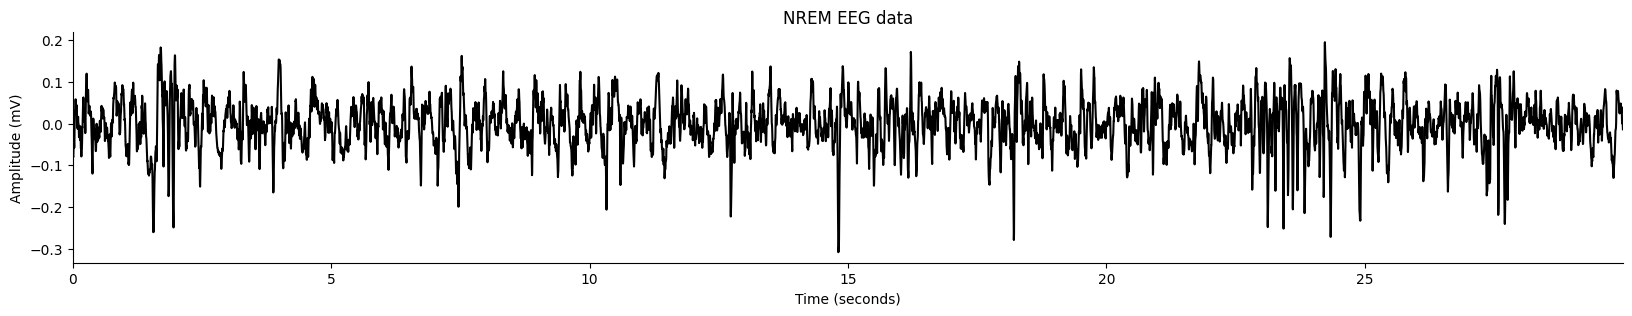

In [47]:
data = misleep.load_mat(
    r"E:\workplace\EEGProcessing\00_DATA\20240117_0700_WXQ_3mice_24h\mouse2\mouse2.mat")
label = misleep.load_misleep_anno(r"E:\workplace\EEGProcessing\00_DATA\20240117_0700_WXQ_3mice_24h\mouse2\mouse2_label.txt")

data = data.signals[0][int(906*305):int(936*305)]
label = label.sleep_state[906:936]*305

# Define sampling frequency and time vector
sf = 305.
times = np.arange(data.size) / sf

# Plot the signal
fig, ax = plt.subplots(1, 1, figsize=(20, 3))
plt.plot(times, data, lw=1.5, color='k')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude (mV)')
plt.xlim([times.min(), times.max()])
plt.title('NREM EEG data')
sns.despine()

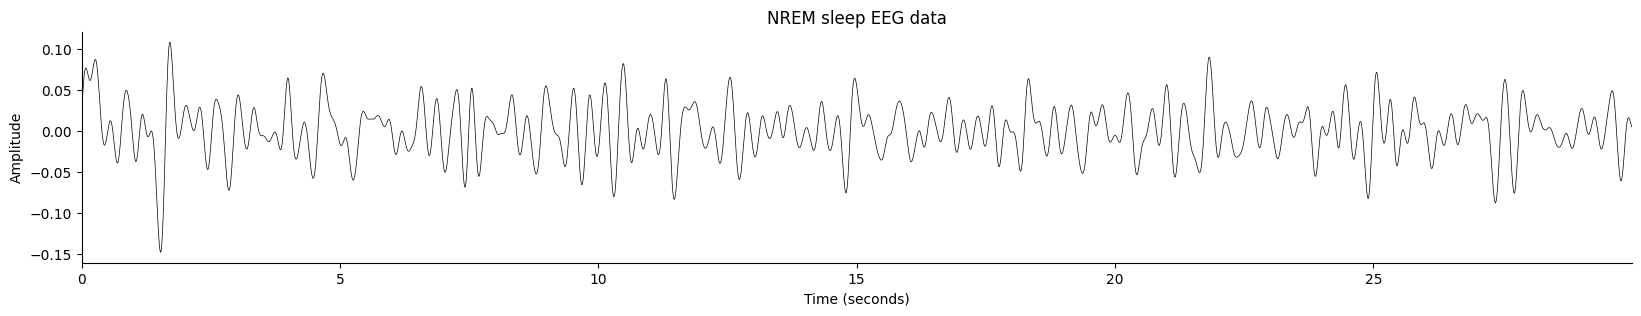

In [48]:
data_filt, _ = misleep.signal_filter(data, sf=305, btype='bandpass', low=0.5, high=4)


plt.figure(figsize=(20, 3))
plt.plot(times, data_filt, lw=0.5, color='k')
# plt.axhline(1, color='green')
# plt.axhline(5, color='red')
# plt.axhline(-1, color='green')
# plt.axhline(-5, color='red')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.xlim([0, times[-1]])
plt.title('NREM sleep EEG data')
sns.despine()

In [49]:
peaks_pos = signal.find_peaks(data_filt, (0.05))
peaks_neg = signal.find_peaks(-1*data_filt, (0.05))

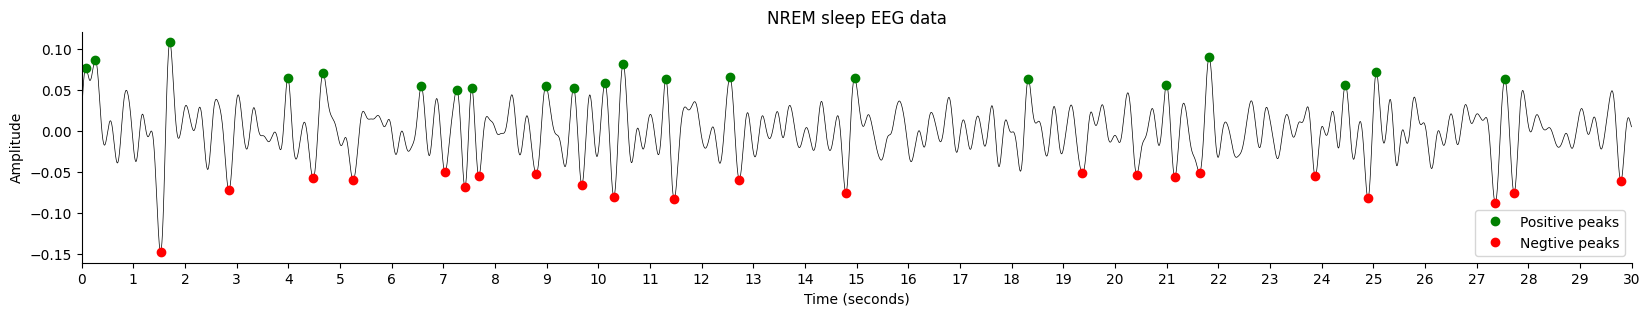

In [50]:
plt.figure(figsize=(20, 3))
plt.plot(times, data_filt, lw=0.5, color='k')

plt.plot(peaks_pos[0]/sf, peaks_pos[1]['peak_heights'], 'go', label='Positive peaks')
plt.plot(peaks_neg[0]/sf, -1*peaks_neg[1]['peak_heights'], 'ro', label='Negtive peaks')

plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.xlim([0, times[-1]])
plt.xticks(range(0, 31))
plt.title('NREM sleep EEG data')
plt.legend()
sns.despine()

In [51]:
sw = sw_detect(data, sf, hypno=label, include=(1), freq_sw=(0.5, 4),
               dur_neg=(0.1, 2), dur_pos=(0.1, 2),
               amp_neg=(0.05, 0.15), amp_pos=(0.05, 0.15), amp_ptp=(0.1, 0.5))

events = sw.summary()
events.round(2)

11-Apr-24 16:44:27 | ERROR | Wrong data amplitude for CHAN000 (trimmed STD = 0.042). Unit of data MUST be uV! Channel will be skipped.
11-Apr-24 16:44:27 | WARNING | All channels have bad amplitude. Returning None.


AttributeError: 'NoneType' object has no attribute 'summary'

array([0, 0, 0, ..., 0, 0, 0])

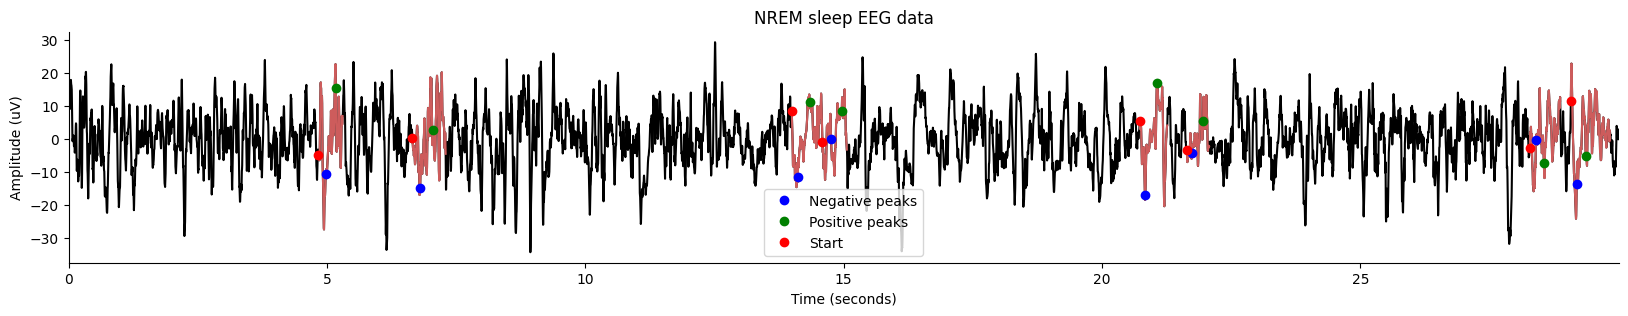

In [144]:
# Let's get a mask indicating for each sample
mask = sw.get_mask()
mask

sw_highlight = data * mask
sw_highlight[sw_highlight == 0] = np.nan

plt.figure(figsize=(20, 3))

plt.plot(times, data, 'k')
plt.plot(times, sw_highlight, 'indianred')
plt.plot(events['NegPeak'], sw_highlight[(events['NegPeak'] * sf).astype(int)], 'bo', label='Negative peaks')
plt.plot(events['PosPeak'], sw_highlight[(events['PosPeak'] * sf).astype(int)], 'go', label='Positive peaks')
plt.plot(events['Start'], data[(events['Start'] * sf).astype(int)], 'ro', label='Start')

plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude (uV)')
plt.xlim([0, times[-1]])
plt.title('NREM sleep EEG data')
plt.legend()
sns.despine()

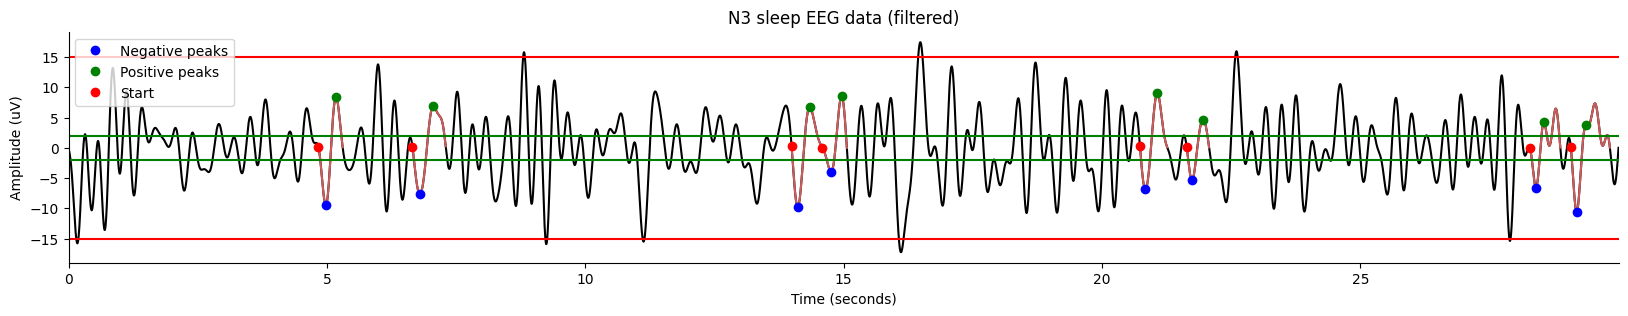

In [145]:
data_filt = np.squeeze(sw._data_filt)
data_filt

sw_highlight = data_filt * mask
sw_highlight[sw_highlight == 0] = np.nan

plt.figure(figsize=(20, 3))

plt.plot(times, data_filt, 'k')
plt.plot(times, sw_highlight, 'indianred')

plt.axhline(2, color='green')
plt.axhline(15, color='red')
plt.axhline(-2, color='green')
plt.axhline(-15, color='red')
plt.plot(events['NegPeak'], events['ValNegPeak'], 'bo', label='Negative peaks')
plt.plot(events['PosPeak'], events['ValPosPeak'], 'go', label='Positive peaks')
plt.plot(events['Start'], np.squeeze(sw._data_filt)[(events['Start'] * sf).astype(int)], 'ro', label='Start')

plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude (uV)')
plt.xlim([0, times[-1]])
plt.title('N3 sleep EEG data (filtered)')
plt.legend()
sns.despine()

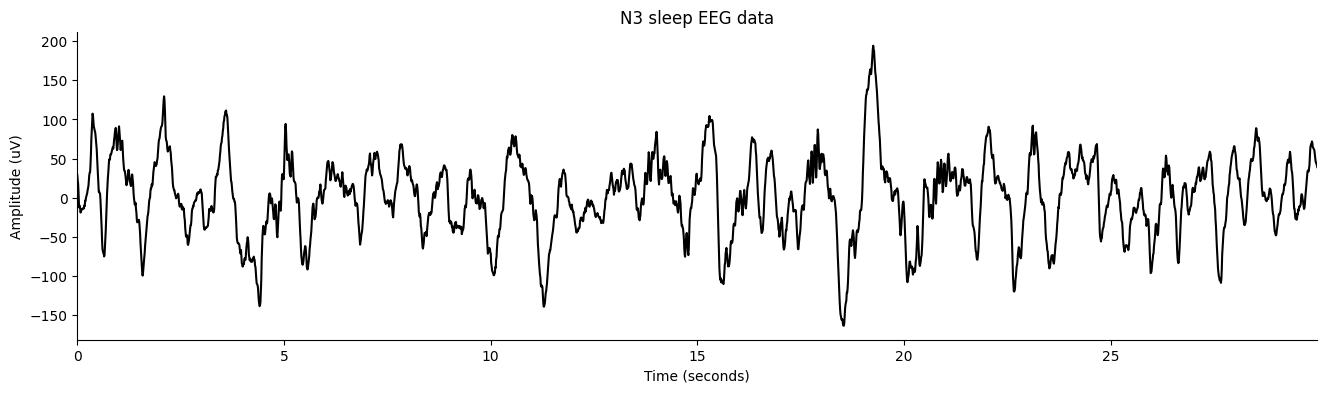

In [49]:
# Load data
data = np.load('./data_full_6hrs_100Hz_Cz+Fz+Pz.npz').get('data')
ch_names = ['Cz', 'Fz', 'Pz']
hypno = np.load('./data_full_6hrs_100Hz_hypno.npz').get('hypno')

# Keep only Fz and during a N3 sleep period with (huge) slow-waves
data = data[1, 669000:672000].astype(np.float64)
hypno = hypno[669000:672000]

# Define sampling frequency and time vector
sf = 100.
times = np.arange(data.size) / sf

# Plot the signal
fig, ax = plt.subplots(1, 1, figsize=(16, 4))
plt.plot(times, data, lw=1.5, color='k')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude (uV)')
plt.xlim([times.min(), times.max()])
plt.title('N3 sleep EEG data')
sns.despine()

In [57]:
sw = sw_detect(data, sf, hypno=hypno, include=(2, 3), freq_sw=(0.5, 4))

event = sw.summary()
event.round(2)

,Start,NegPeak,MidCrossing,PosPeak,End,Duration,ValNegPeak,ValPosPeak,PTP,Slope,Frequency,Stage,Channel,IdxChannel
0,1.32,1.59,1.77,2.07,2.33,1.01,-96.06,89.44,185.50,1030.55,0.99,3,CHAN000,0
1,8.19,8.39,8.57,8.86,8.99,0.80,-54.04,53.16,107.20,595.54,1.25,3,CHAN000,0
2,9.82,10.06,10.29,10.53,11.03,1.21,-87.14,77.78,164.92,717.05,0.83,3,CHAN000,0
3,11.03,11.29,11.57,11.73,12.01,0.98,-115.37,59.49,174.86,624.49,1.02,3,CHAN000,0
4,13.46,13.59,13.77,13.97,14.34,0.88,-50.30,38.56,88.86,493.69,1.14,3,CHAN000,0
5,14.34,14.73,14.87,14.95,15.47,1.13,-73.30,14.94,88.24,630.27,0.88,3,CHAN000,0
6,19.72,20.14,20.47,20.55,20.62,0.90,-93.34,24.62,117.96,357.44,1.11,3,CHAN000,0
7,22.52,22.70,22.93,23.12,23.34,0.82,-97.08,93.81,190.89,829.98,1.22,3,CHAN000,0
8,23.34,23.56,23.78,23.95,24.41,1.07,-85.36,36.96,122.31,555.96,0.93,3,CHAN000,0
9,25.21,25.35,25.53,25.74,25.84,0.63,-54.85,28.19,83.03,461.30,1.59,3,CHAN000,0
